In [ ]:
import os
from typing import List, Tuple
from copy import deepcopy
from PIL import Image

import numpy as np
import cv2

from doclayout_yolo import YOLOv10
from huggingface_hub import hf_hub_download

from unstructured_inference.models.base import get_model, get_default_model_mappings
from unstructured_inference.inference.layout import DocumentLayout, PageLayout

import doctr
from doctr.io import DocumentFile
from doctr.models.detection.zoo import detection_predictor
from doctr.models.zoo import ocr_predictor
from doctr.utils.visualization import draw_boxes

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

import matplotlib.pyplot as plt
from matplotlib import patches as pat 




In [126]:
%cd /data/hpc/potato/ecoit_summer
%pwd

/data/hpc/potato/ecoit_summer


'/data/hpc/potato/ecoit_summer'

In [127]:
filepath = hf_hub_download(repo_id="juliozhao/DocLayout-YOLO-DocStructBench", filename="doclayout_yolo_docstructbench_imgsz1024.pt")
model = YOLOv10(filepath)
u_model = get_model("yolox")
# predictor = ocr_predictor(det_arch='db_resnet50', reco_arch="sar_resnet31", pretrained=True, device="cuda:3")

*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:505 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************


In [108]:
def chunk_image_to_squares(
    image: np.ndarray,
    overlap: float
) -> List[Tuple[np.ndarray, Tuple[int, int]]]:
    """
    Split an image into overlapping square patches.

    Parameters
    ----------
    image : np.ndarray
        Input image array (H, W, C) or (H, W).
    patch_size : int
        Size of each square patch (patch_size x patch_size).
    overlap : int
        Number of pixels to overlap between consecutive patches.

    Returns
    -------
    patches : List[Tuple[np.ndarray, Tuple[int, int]]]
        List of (patch, (y, x)) where patch is a patch array and (y, x) is its top-left position.
    """

    H, W = image.shape[:2]
    patch_size = min(H, W)
    stride = int(patch_size * (1 - overlap))
    patches, coords = [], []
    x = list(range(0, W - patch_size + 1, stride)) + [W - patch_size]
    y = list(range(0, H - patch_size + 1, stride)) + [H - patch_size]
    xx, yy = np.meshgrid(x, y)
    for x, y in zip(xx.flatten(), yy.flatten()):
        patches.append(image[y:y+patch_size, x:x+patch_size])
        coords.append((y, x))
    return patches, coords

In [119]:
index = 1
image = cv2.imread(f"./logs/document_{index:03d}.png", cv2.IMREAD_UNCHANGED)

In [120]:
patches, coords = chunk_image_to_squares(image.copy(), 0.5)
# patches, coords = zip(*patches)

In [121]:
len(patches)

4

In [132]:
det_res = model.predict(
    patches,  # Image to predict
    conf=0.1,        # Confidence threshold
    device="cuda:0"    # Device to use (e.g., 'cuda:0' or 'cpu')
)
u_det_res = PageLayout.from_image(Image.fromarray(image), number=0, detection_model=u_model, fixed_layout=None)
u_layout_els = u_det_res.elements


0: 1024x1024 4 titles, 12 plain texts, 33.0ms
1: 1024x1024 4 titles, 12 plain texts, 33.0ms
2: 1024x1024 1 title, 9 plain texts, 1 abandon, 33.0ms
3: 1024x1024 1 title, 9 plain texts, 1 abandon, 33.0ms
Speed: 10.5ms preprocess, 33.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


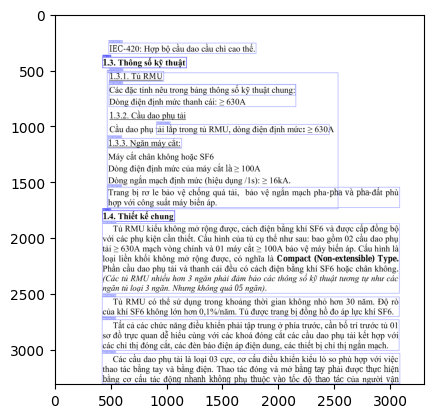

In [133]:
# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
plt.imshow(annotated_frame)

AttributeError: 'list' object has no attribute 'Rectangle'

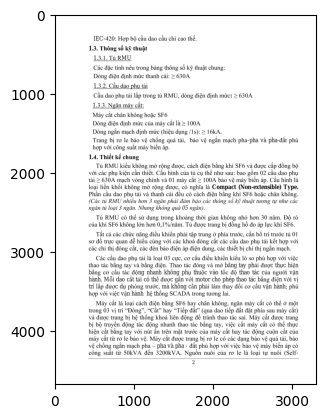

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(image)
for el in u_layout_els: 
    if el.bbox is not None:
        ax.add_patch(patches.Rectangle((el.bbox.x1, el.bbox.y1), el.bbox.x2 - el.bbox.x1, el.bbox.y2 - el.bbox.y1, fill=False, edgecolor='red', linewidth=2))
plt.show()

In [118]:
image = cv2.imread("/data/hpc/potato/ecoit_summer/logs/example.png")
print(image.shape)

(2340, 1655, 3)


In [76]:
# doc = DocumentFile.from_images([ "/data/hpc/potato/ecoit_summer/logs/example.png"]) 
result = predictor([image], return_maps=True)

NameError: name 'predictor' is not defined

In [ ]:
result

([{'words': array([[    0.31774,     0.91309,     0.36469,     0.93262,     0.55367],
          [    0.81067,     0.91406,     0.83138,     0.92871,     0.45292],
          [    0.27908,     0.91309,     0.31774,     0.92969,      0.5703],
          ...,
          [    0.13824,    0.072266,     0.16862,    0.086914,     0.53944],
          [    0.80653,    0.069336,     0.84105,    0.085938,     0.54026],
          [    0.50552,    0.026367,     0.51795,    0.040039,     0.33015]], shape=(375, 5))}],
 [array([[[ 5.1069e-06],
          [ 4.9961e-06],
          [ 7.7269e-06],
          ...,
          [ 3.8855e-05],
          [ 4.1803e-05],
          [ 4.2979e-05]],
  
         [[ 5.3729e-06],
          [ 7.6216e-06],
          [ 8.0104e-06],
          ...,
          [ 3.8391e-05],
          [ 1.9495e-05],
          [ 2.6379e-05]],
  
         [[ 2.4333e-05],
          [ 2.7211e-05],
          [ 3.6067e-05],
          ...,
          [ 8.0398e-06],
          [ 1.6842e-06],
          [ 2.77

[1655, 2340, 1655, 2340]


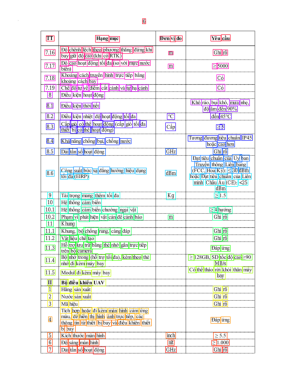

In [ ]:
# page_img, page = cv2.imread("/data/hpc/potato/ecoit_summer/logs/example.png"), result.pages[0]
# print(page_img.shape)
# quads = []
# for block in page.blocks:
#     for line in block.lines:
#         for word in line.words:
            
#             # word.geometry is a 4-point quadrilateral ((x,y) in [0,1])
#             quads.append(np.array(word.geometry, dtype=np.float32).flatten())
# quads = np.stack(quads, axis=0)
figure = image.copy()
xy_shape = list(image.shape[:2][::-1])
xy_shape.extend(xy_shape)
print(xy_shape)
quads = (result[0][0]['words'][:, :4] * xy_shape).astype(int)
cmap = plt.get_cmap("hsv")
imgs = []
for index, box in enumerate(quads.tolist()):
        color = cmap(index / len(quads))
        xmin, ymin, xmax, ymax = box
        figure = cv2.rectangle(
            figure, (xmin, ymin), (xmax, ymax), color= [int(c * 255) for c in color], thickness=2
        )
        
        imgs.append(Image.fromarray(image[ymin:ymax, xmin:xmax].copy()))
cv2.imwrite("./logs/det_res.png", figure)
plt.imshow(figure)
plt.axis("off")
plt.show()

In [ ]:
temp_dir = "data/temp"
id = 0
imgs = []
database = {"data_dir": "/data/hpc/potato/ecoit_summer/data/temp", "name": "example.png", "page": 5, "objects": dict()}
for block_id, block in enumerate(page.blocks):
    for line_id, line in enumerate(block.lines):
        for word_id, word in enumerate(line.words):
            object_id = f"{block_id}_{line_id}_{word_id}"
            tmp_path = os.path.join(temp_dir, f"{object_id}.png")
            geometry = (np.array(word.geometry, dtype=np.float32) * page_img.shape[:2][::-1]).astype(int)
            print(geometry)
            imgs.append(Image.fromarray(page_img[geometry[0, 1]:geometry[1, 1], geometry[0, 0]:geometry[1, 0]]))
            object = {"image": f"{object_id}.png", "det": geometry.tolist()}
            database['objects'][object_id] = object
            cv2.imwrite(tmp_path, page_img[geometry[0, 1]:geometry[1, 1], geometry[0, 0]:geometry[1, 0]])
quads = np.stack(quads, axis=0)

NameError: name 'page' is not defined

In [ ]:
import json
with open(os.path.join(temp_dir, "json/detection.json"),"w") as file:
    json.dump(database, file, indent=4)

In [ ]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [ ]:
config = Cfg.load_config_from_name('vgg_seq2seq')
config['cnn']['pretrained']=True
config['device'] = 'cuda:0'
rec_model = Predictor(config)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/hpc/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [01:01<00:00, 9.37MB/s] 


Model weight /tmp/vgg_seq2seq.pth exsits. Ignore download!


In [ ]:
config

{'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
 'device': 'cuda:0',
 'seq_modeling': 'seq2seq',
 'transformer': {'encoder_hidden': 256,
  'decoder_hidden': 256,
  'img_channel': 256,
  'decoder_embedded': 256,
  'dropout': 0.1},
 'optimizer': {'max_lr': 0.001, 'pct_start': 0.1},
 'trainer': {'batch_size': 32,
  'print_every': 200,
  'valid_every': 4000,
  'iters': 100000,
  'export': './weights/transformerocr.pth',
  'checkpoint': './checkpoint/transformerocr_checkpoint.pth',
  'log': './train.log',
  'metrics': None},
 'dataset': {'name': 'data',
  'data_root': './img/',
  'train_annotation': 'annotation_train.txt',
  'valid_annotation': 'annotation_val_small.txt',
  'image_height': 32,
  'image_min_width': 32,
  'image_max_width': 512},
 'dataloader': {'num_workers': 3, 'pin_memory': True}

In [ ]:
rec_words = []
rec_probs = []
for i in range(0, len(imgs),4):
    rec_res  = rec_model.predict_batch(imgs[i:min(len(imgs), i+4)], return_prob=True)
    rec_words.extend(rec_res[0])
    rec_probs.extend(rec_res[1])

In [ ]:
rec_words

['động',
 'rõ',
 'hoạt',
 'GHz',
 'Dải',
 'Ghi',
 'số',
 'tân',
 '7',
 's',
 '1.000',
 'nit',
 'hình',
 'màn',
 'sáng',
 'Độ',
 '6',
 '5.5',
 'hình',
 'màn',
 'thước',
 'inch',
 'Kích',
 '5',
 'bay',
 'bị',
 'bay',
 'thông',
 'khiến',
 'và',
 'bị',
 'từ',
 'tin',
 'điều',
 'thiết',
 'thiết',
 'Đáp',
 'ứng',
 '4',
 'trực',
 'các',
 'tiếp.',
 'ảnh',
 'hình',
 'màu,',
 'thị',
 'hiến',
 'để',
 'ứng',
 'cảm',
 'màn',
 'hình',
 'kèm',
 'hoặc',
 'hợp',
 'Tích',
 'đi',
 'rõ',
 'hiệu',
 'Mã',
 'Ghi',
 '3',
 'sản',
 'rõ',
 'xuất',
 'Ghi',
 'Nước',
 '2',
 'sản',
 'rõ',
 'xuất',
 'Hãng',
 'Ghi',
 '1',
 'UAV',
 'khiển',
 'Bộ',
 'điều',
 'H',
 'bay',
 'bay',
 'máy',
 'kèm',
 'Modul',
 'đi',
 '11.5',
 'máy',
 'thân',
 'khỏi',
 'tháo',
 'Có',
 'thế',
 'rời',
 'MB/s',
 'bay',
 'máy',
 'kèm',
 'nhớ',
 'đi',
 '11.4',
 'cao',
 'trong',
 'trợ',
 '128GB,',
 's',
 'theo',
 'kèm',
 'đa),',
 '90',
 'độ',
 'tốc',
 'SD',
 'thẻ',
 'Bộ',
 'tôi',
 '(ỗỗ',
 'nhớ',
 'camera',
 'bộ',
 'trên',
 'ứng',
 'Đáp',
 '11.3',
 

In [ ]:
final = list(zip(quads.tolist(), rec_words, rec_probs))

In [ ]:
final

[([525, 2136, 603, 2182], 'động', 0.8761467635631561),
 ([1341, 2138, 1375, 2173], 'rõ', 0.7186772525310516),
 ([461, 2136, 525, 2175], 'hoạt', 0.8852089792490005),
 ([982, 2134, 1051, 2173], 'GHz', 0.7472308774789175),
 ([317, 2134, 377, 2175], 'Dải', 0.8202348748842875),
 ([1282, 2132, 1339, 2173], 'Ghi', 0.8902659217516581),
 ([423, 2132, 464, 2175], 'số', 0.6967867612838745),
 ([370, 2127, 427, 2177], 'tân', 0.887181560198466),
 ([237, 2132, 267, 2170], '7', 0.9203023910522461),
 ([1273, 2095, 1305, 2127], 's', 0.16603940725326538),
 ([1305, 2090, 1385, 2127], '1.000', 0.9141822695732117),
 ([996, 2093, 1037, 2127], 'nit', 0.898669441541036),
 ([503, 2090, 562, 2127], 'hình', 0.8769091218709946),
 ([436, 2090, 500, 2127], 'màn', 0.8955422043800354),
 ([365, 2088, 439, 2134], 'sáng', 0.8877919316291809),
 ([317, 2088, 370, 2132], 'Độ', 0.8781756162643433),
 ([237, 2088, 267, 2127], '6', 0.905131459236145),
 ([1284, 2045, 1371, 2090], '5.5', 0.7543211181958517),
 ([541, 2047, 603, 20